# U.S. Treasury Yield Curve Forecasting using LSTM


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr
from matplotlib import pyplot as plt

## Import data

In [2]:
# Import yield data from the data folder
df = pd.read_csv('../data/yield.csv')
df = df.set_index('DATE')
df.index = pd.to_datetime(df.index)
name = list(df.columns.values)

df

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2005-01-03,1.99,2.32,2.63,2.79,3.10,3.28,3.64,3.94,4.23,4.84,4.85
2005-01-04,2.05,2.33,2.63,2.82,3.20,3.38,3.72,4.02,4.29,4.91,4.91
2005-01-05,2.04,2.33,2.63,2.83,3.22,3.39,3.73,4.02,4.29,4.88,4.88
2005-01-06,2.04,2.31,2.63,2.82,3.18,3.36,3.71,4.01,4.29,4.88,4.89
2005-01-07,2.03,2.32,2.63,2.82,3.20,3.40,3.73,4.03,4.29,4.88,4.88
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,4.35,4.18,3.96,3.77,3.61,3.58,3.69,3.92,4.22,4.85,4.90
2025-09-04,4.33,4.16,3.94,3.76,3.59,3.55,3.65,3.87,4.17,4.81,4.86
2025-09-05,4.29,4.07,3.85,3.65,3.51,3.48,3.59,3.80,4.10,4.72,4.78


In [48]:
# Split into training 85%/ validation 10% / testing 5% 
n_train_end = int(len(df[:-756])*0.8)
n_valid_end = -756
df_train = df.iloc[:n_train_end]
df_valid = df.iloc[n_train_end:n_valid_end]
df_test = df.iloc[n_valid_end:]


## LSTM

### Data preprocessing

In [72]:
# Preprocess score data
scaler = StandardScaler()
scaler.fit(df_train)
scaled_data = scaler.transform(df)
scaled_data_train = scaler.transform(df_train)

# Prepare LSTM input
horizons = [21, 63, 126, 252]

def create_LSTM_input(data, lag, horizon):
    X, Y = [], []
    for i in range(len(data) - lag - horizon + 1):
        X.append(data[i:i+lag])
        Y.append(data[i+lag+horizon-1])
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(Y), dtype=torch.float32)
    return X_tensor, Y_tensor

lag = 20

Xtr, Ytr = create_LSTM_input(scaled_data_train, lag, 1)
Xv, Yv = create_LSTM_input(scaled_data[n_train_end - lag : n_valid_end], lag, 1)
Xte, Yte = [], []
for h in horizons:
    LSTM_input = create_LSTM_input(scaled_data[n_valid_end - lag - h + 1:], lag, h)
    Xte.append(LSTM_input[0])
    Yte.append(LSTM_input[1])
#Xte, Yte = create_LSTM_input(scaled_data[n_valid_end - lag:], lag)

# Wrap the data in torch TensorDataset, DataLoader
dataset = TensorDataset(Xtr, Ytr)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


### Construct LSTM model

In [50]:
# Construct LSTM model

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers,
                            dropout = dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)               # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]                 # use last output for forecasting
        out = self.linear(out)              # project to output dimension
        return out

model = LSTM(input_dim=11, hidden_dim=128, output_dim=11)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

### Train model

In [53]:
# Train LSTM model
model.train()
for epoch in range(epochs):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_func(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.0071
Epoch 1: loss = 0.0250
Epoch 2: loss = 0.0012
Epoch 3: loss = 0.0071
Epoch 4: loss = 0.0193
Epoch 5: loss = 0.0267
Epoch 6: loss = 0.0216
Epoch 7: loss = 0.0010
Epoch 8: loss = 0.0029
Epoch 9: loss = 0.0056


In [54]:
# Validation
model.eval()
train_loss = loss_func(model(Xtr), Ytr)
val_loss = loss_func(model(Xv), Yv)
print(f'Train loss      : {train_loss}')
print(f'Validation loss : {val_loss}')

Train loss      : 0.006811969913542271
Validation loss : 0.0407327339053154


In [73]:
# Forecast
model.eval()
yield_fore = []

with torch.no_grad():
    for i in range(4):
        fore = []
        for x in Xte[i]:
            x = x.unsqueeze(0)
            #print(x)
            for _ in range(horizons[i]):      # Rolling forecast
                y = model(x)
                y = y.unsqueeze(0)
                x = torch.cat((x,y), dim=1)[:,1:,:]
                #print(x)
            forecast = scaler.inverse_transform(y.squeeze(0).numpy())
            fore.append(forecast[0])
        yield_fore.append(pd.DataFrame(np.array(fore), columns=df.columns, index=df_test.index))
        
# Transfrom forecasted scores into yields
yield_fore

[                 1MO       3MO       6MO       1YR       2YR       3YR  \
 DATE                                                                     
 2022-08-30  2.781111  2.929631  3.039190  3.281046  3.371985  3.319832   
 2022-08-31  2.794639  2.944319  3.052685  3.295790  3.385562  3.331224   
 2022-09-01  2.808868  2.959762  3.066869  3.311405  3.399907  3.342987   
 2022-09-02  2.808252  2.959008  3.066184  3.310907  3.399206  3.341623   
 2022-09-06  2.857679  3.013060  3.115716  3.364169  3.448944  3.385608   
 ...              ...       ...       ...       ...       ...       ...   
 2025-09-03  2.624009  2.659470  2.917385  2.831304  2.652644  2.715269   
 2025-09-04  2.606284  2.642599  2.899962  2.817742  2.646251  2.710225   
 2025-09-05  2.591586  2.628623  2.885764  2.806580  2.640477  2.705745   
 2025-09-08  2.585256  2.622709  2.879728  2.802055  2.638576  2.704464   
 2025-09-09  2.587474  2.625000  2.882216  2.804231  2.639981  2.705887   
 
                  5YR  

In [75]:
# RMSE table

def RMSE_table(yield_fores):
    RMSE = []
    for yield_fore in yield_fores:
        RMSE.append(np.sqrt(np.mean((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=0)))
    RMSE = np.array(RMSE)
    ind = ['1', '3', '6', '12']
    return pd.DataFrame(RMSE, columns=df.columns, index=ind)

# Save results
RMSE_table(yield_fore).to_csv('../results/LSTM_RMSE.csv', index=False)
RMSE_table(yield_fore)

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
1,0.673707,0.612853,0.477221,0.476198,0.557703,0.605457,0.603646,0.547382,0.524620,0.438081,0.451397
3,1.189150,1.111202,0.912874,0.816583,0.785324,0.755898,0.681771,0.638948,0.638316,0.569570,0.601744
6,2.239442,2.144836,1.827533,1.631677,1.459138,1.285685,0.931228,0.747337,0.592936,0.536880,0.575679
12,4.022317,3.956937,3.723784,3.379539,2.794393,2.312332,1.575414,1.179691,0.892758,0.724687,0.625178


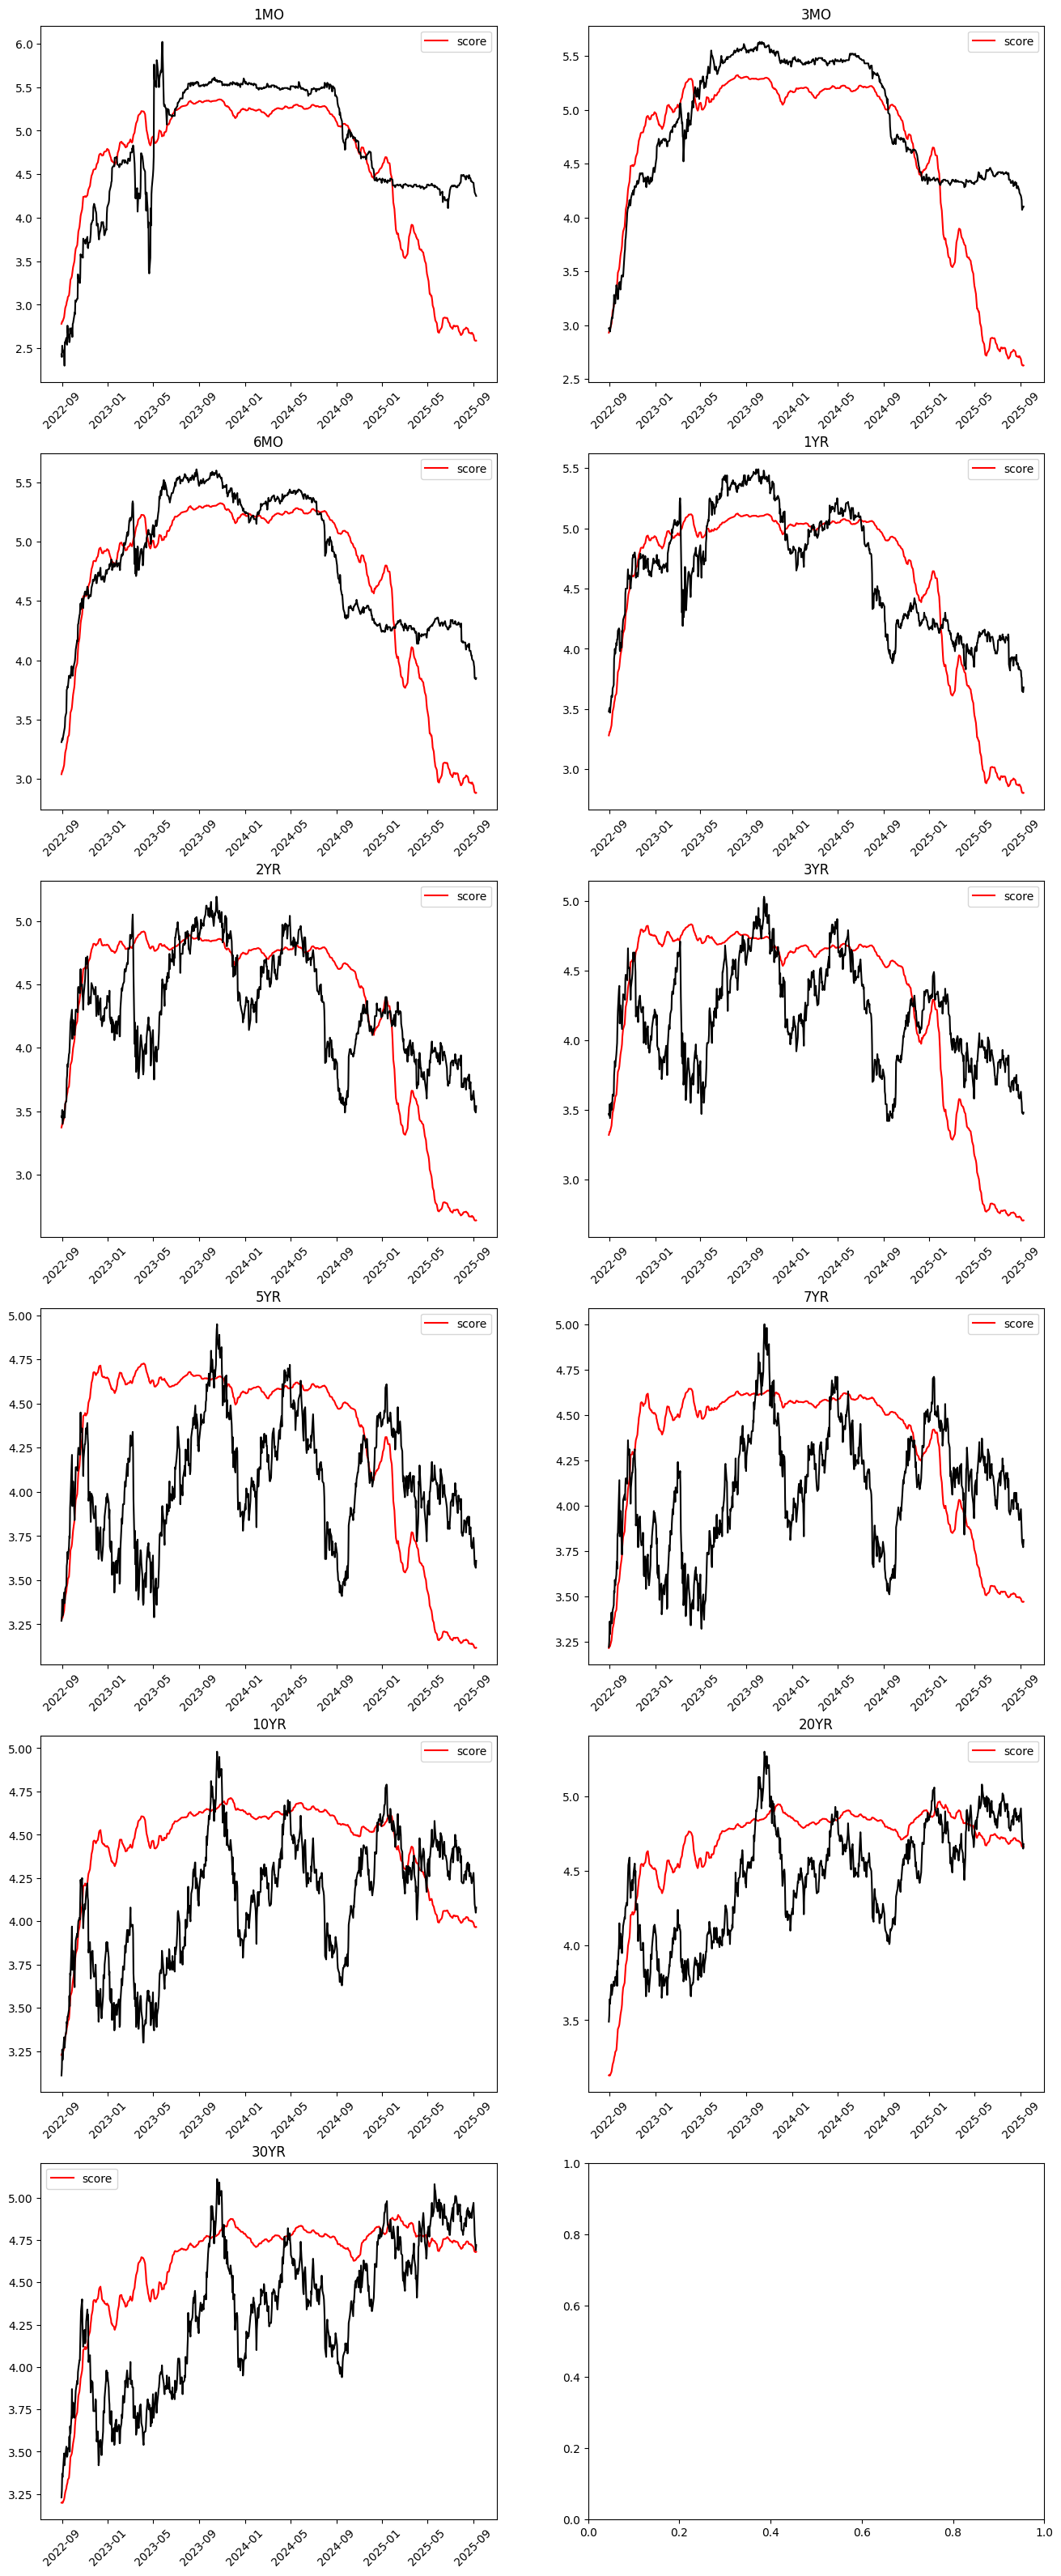

In [76]:
# Plot the forecasted (1 month ahead) vs actual yield
fig, ax = plt.subplots(6,2,figsize=(16,40))

for i in range(6):
    for j in range(2):
        ind = 2*i+j
        if ind == len(name): break
        ax[i, j].plot(yield_fore[0][name[ind]], color='red', label='score')
        ax[i, j].plot(df_test[name[ind]], color='black')
        ax[i, j].legend()
        ax[i, j].tick_params('x', labelrotation=45)
        ax[i, j].set_title(name[ind])